In [1]:
import os
import torch
torch.manual_seed(int(1e9+7e7+17+3))
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
# %matplotlib widget
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from ilt_data import PNGFolderDataset, tensor_to_image
from ilt_model import DualLithoZernikeRegressor
# torch.multiprocessing.set_start_method('spawn') # extremely slow
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, message='Torchinductor does not support code generation for complex operators. Performance may be worse than eager.')

In [2]:
DATASET_ROOT = os.path.join('..', 'dataset', 'train_layouts')
workers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.zeros((1,), device=device)

In [3]:
# -------- 3. DataLoader --------
def make_dataloaders(root, batch_size=16, num_zernike=20, split=0.8, workers=1, load_all_to_ram=False):
    dataset = PNGFolderDataset(root, N_zernike=num_zernike, image_size=1024, aberr_max=6.,
                               device=dataset_device, load_all_to_ram=load_all_to_ram, num_threads=workers)
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    return train_loader, val_loader, dataset

## Train

Aberrations: Z=[-9.9025704e-03 -3.0470660e+00  1.3667786e-01 -4.0827855e-03
  8.1856376e-01  3.7618944e-09 -2.5245436e-02 -2.0244482e+00
 -1.2266799e-03  1.7481959e-01 -1.6764041e+00  1.4575389e-03
  6.7406520e-02 -4.2915401e-01  2.4903512e-01]


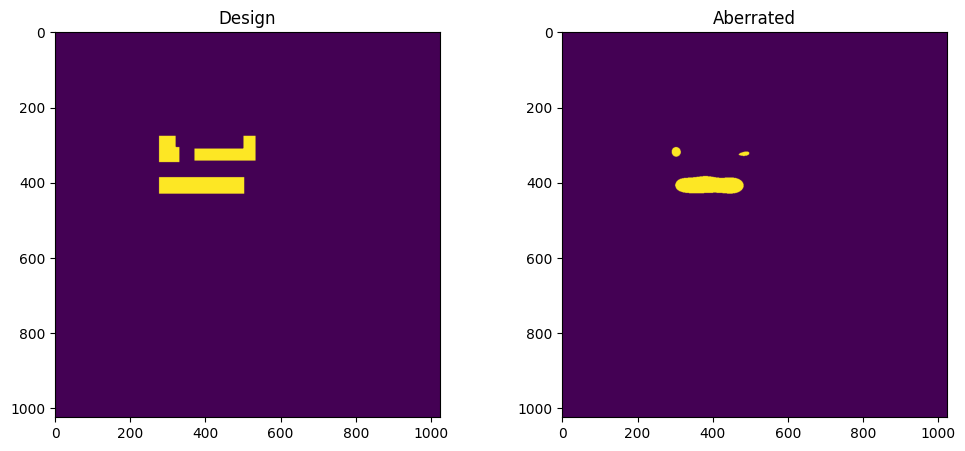

In [4]:
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=1, num_zernike=15, workers=0)
a = next(iter(train_loader))
i = 0

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][0]))
ax.set_title("Design")
ax = plt.subplot(1,2,2)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][1]))
ax.set_title("Aberrated")
print(f"Aberrations: Z={a[1][i].cpu().numpy()}")
plt.show()

In [ ]:
# -------- 4. Training --------
"mobilenet_v3_small" # 1.5 M / 1.06 m
"mobilenet_v3_large" # 4.2 M / 1.13 m
"efficientnet_b0"    # 4.0 M / 1.45 m
"efficientnet_b2"    # 7.7 M
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=16, num_zernike=15, workers=0, load_all_to_ram=True)
warmup_epochs = 1
accumulate_grad_batches = 8
warmup_steps = warmup_epochs * len(train_loader) / accumulate_grad_batches
model = DualLithoZernikeRegressor("mobilenet_v3_large", num_zernike=15, lr=1e-3, warmup_steps=warmup_steps)
# model = DualLithoZernikeRegressor.load_from_checkpoint(
# "lightning_logs/Dual Mobilenet_v3 1024 v3/checkpoints/best-model.ckpt")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best-model'
)
logger = TensorBoardLogger(".", name="lightning_logs", version="Dual Mobilenet_v3 1024 v3")

trainer = Trainer(max_epochs=200, accelerator="auto", callbacks=[checkpoint_callback],
                  accumulate_grad_batches = accumulate_grad_batches, #gradient_clip_val=1.,
                  logger=logger,
                  precision="16-mixed",
                  # devices=[1],
          )
trainer.fit(model, train_loader, val_loader, ckpt_path="lightning_logs/Dual Mobilenet_v3 1024 v3/checkpoints/best-model-v1.ckpt")

Caching images: 100%|██████████| 4875/4875 [01:23<00:00, 58.08it/s]
/home/vvkakurin/.conda/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vvkakurin/.conda/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vvkakurin/.conda/envs/SK/lib/python3.11/site-packages/pytorch_lightning/callbacks/m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/vvkakurin/.conda/envs/SK/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
final_val_loss = trainer.callback_metrics['val_loss'].item()
print('Final validation loss:', final_val_loss)

In [ ]:
# assert False

## Test

In [ ]:
batch = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imgs, z_true = batch
imgs, z_true = imgs[:8].to(device), z_true[:8].to(device)

In [ ]:
# #### CLEAR CACHE #####
# model.cpu()
# from gc import collect
# imgs, z_true = None, None
# litho_imgs, aberr_imgs, restored_imgs = None, None, None
# z_preds = None
# batch = None
# collect()
# torch.cuda.empty_cache()
# collect()

In [ ]:
model.to(device)
litho_aberr_imgs = imgs[:, 1:]
z_preds, z_rev_preds = model(litho_aberr_imgs)
print(z_preds[0], z_true[0], z_rev_preds[0], sep='\n')

In [ ]:
design_imgs, litho_imgs, aberr_imgs = torch.split(imgs, 1, dim=1) # [B, 3, H, W] -> [B, (1, 1, 1), H, W]
with torch.autocast(device_type=device.type):
    modelled_imgs = model.sim.run_lithosim(design_imgs, zernike_coeffs=z_preds)
    reconstructed_imgs = model.sim.run_lithosim(aberr_imgs, zernike_coeffs=z_rev_preds)

In [ ]:
# z = z_preds[:1].clone()
# z_rev = z_rev_preds[:1].clone()
# # z[0,-2] = 1.
# # litho = litho_imgs[:1]
# with torch.autocast(device_type=device.type):
#     aberr = model.sim.run_lithosim(design_imgs[:1], zernike_coeffs=z)
#     reconstr = model.sim.run_lithosim(aberr_imgs[:1], zernike_coeffs=z_rev)
    
# fig = plt.figure(figsize=(14,4))
# ax = plt.subplot(2,3,1)
# # plt.imshow(dataset.intensity_tensor_to_image(litho[0]))
# # # ax.set_title(f"Design {i+1}")
# # ax = plt.subplot(1,2,2)
# # plt.imshow(dataset.intensity_tensor_to_image(aberr[0]))
# plt.imshow(tensor_to_image(litho_imgs[0]))
# # ax.set_title(f"Design {i+1}")
# ax = plt.subplot(1,2,2)
# plt.imshow(tensor_to_image(aberr[0]))
# # ax.set_title(f"Aberrated {i+1}")
# print(z_preds[:1])

for i in range(imgs.shape[0]):

    fig = plt.figure(figsize=(14,4))
    ax = plt.subplot(1,4,1)
    plt.imshow(tensor_to_image(litho_imgs[i]), cmap='inferno')
    ax.set_title(f"Design (aerial) {i+1}")
    ax = plt.subplot(1,4,2)
    plt.imshow(tensor_to_image(reconstructed_imgs[i]), cmap='inferno')
    ax.set_title(f"Reconstructed {i+1}")
    ax = plt.subplot(1,4,3)
    plt.imshow(tensor_to_image(aberr_imgs[i]), cmap='inferno')
    ax.set_title(f"Aberrated {i+1}")
    ax = plt.subplot(1,4,4)
    plt.imshow(tensor_to_image(modelled_imgs[i]), cmap='inferno')
    ax.set_title(f"Modelled {i+1}")
    print(f"Aberrations: Z={z_true[i].cpu().numpy()}", 
          f"Preds={z_preds[i].detach().cpu().numpy()}", 
          f"Inverse={z_rev_preds[i].detach().cpu().numpy()}")
    plt.show()

In [ ]:
plt.plot(tensor_to_image(litho_imgs[0])[220])
plt.plot(tensor_to_image(aberr_imgs[0])[220])

In [ ]:
# i = 1
for i in range(imgs.shape[0]):

    fig = plt.figure(figsize=(14,4))
    ax = plt.subplot(1,3,1)
    plt.imshow(dataset.intensity_tensor_to_image(design_imgs[i]))
    ax.set_title(f"Design {i+1}")
    ax = plt.subplot(1,3,2)
    plt.imshow(dataset.intensity_tensor_to_image(aberr_imgs[i]))
    ax.set_title(f"Aberrated {i+1}")
    ax = plt.subplot(1,3,3)
    plt.imshow(dataset.intensity_tensor_to_image(modelled_imgs[i]))
    ax.set_title(f"Reconstructed {i+1}")
    print(f"Aberrations: Z={z_true[i].cpu().numpy()}\nPreds={z_preds[i].detach().cpu().numpy()}")
    plt.show()

In [ ]:
# loss = model.loss_func(restored_imgs, litho_imgs) * 1e4
modelling_loss = model.loss_func(modelled_imgs, aberr_imgs)
reconstruction_loss = model.loss_func(reconstructed_imgs, litho_imgs)
modelling_loss, reconstruction_loss

In [ ]:
for i in range(imgs.shape[0]):

    fig = plt.figure(figsize=(14,4))
    ax = plt.subplot(1,2,1)
    plt.imshow(tensor_to_image(torch.abs(litho_imgs[i] - reconstructed_imgs[i])), cmap='inferno')
    plt.colorbar()
    ax.set_title(f"||Design - Reconstructed|| {i+1}")
    ax = plt.subplot(1,2,2)
    plt.imshow(tensor_to_image(torch.abs(aberr_imgs[i] - modelled_imgs[i])), cmap='inferno')
    plt.colorbar()
    ax.set_title(f"||Aberrated - Modelled|| {i+1}")
    print(f"Aberrations: Z={z_true[i].cpu().numpy()}", 
          f"Preds={z_preds[i].detach().cpu().numpy()}", 
          f"Inverse={z_rev_preds[i].detach().cpu().numpy()}", sep='\n')
    plt.show()

In [ ]:
# Получить финальный val_loss
final_val_loss = trainer.callback_metrics['val_loss'].item()
print('Final validation loss:', final_val_loss)

# Где лежит best checkpoint
print('Best model saved at:', checkpoint_callback.best_model_path)

# Сохранить вручную
torch.save(model.state_dict(), 'Dual Mobilenet_v3 1024 v3.pt')